In [1]:
 using Plots, LaTeXStrings, LinearAlgebra, Revise, Statistics

In [2]:
# Define the data generating system (for the purpose of simulation)
Δ = 0.1
A = [0.98 Δ; 0 0.95];
B = [0; Δ;;];
rₓ, rᵤ = size(B)
C = [0 1];
ry = size(C, 1)
D = 0;

V = [0.1;;]
W = 1*diagm([0.1, 0.05])

Q = [1.0;;]
R = [2.0;;]

N = 5
θ = 1 * 1/9
function f(x::Vector{Float64}, u::Vector{Float64})
    x⁺ = zero.(x);
    x⁺ = A * x + B * u + sqrt(W) * randn(size(x⁺))
    x⁺[1] += θ * x[2] ^ 2
    x⁺[2] +=  θ * tanh(1*x[1]) * u[1]
    return x⁺
end

function g(x::Vector{Float64})
    y = x[2] .+ sqrt(V) * randn(1,)
    return y
end

g (generic function with 1 method)

In [3]:
# Adjust the following function to suit your problem formulation
function collectData(T, K)
    # Initial recorded memory length (to infer initial conditions implicitly)
    U = zeros(1,T)
    X = zeros(2,T+1)
    Y = zeros(1,T+1)
    for i in 1:T
        x₀ = X[:,i]
        y₀ = Y[:,i]
        u₀ = K * y₀
        x₁ = f(x₀, u₀)
        X[:,i+1] = x₁
        U[:,i] = u₀
        y₁ = g(x₁)
        Y[:,i+1] = y₁
    end
    return U, X[:,2:end], Y[:,2:end]
end

collectData (generic function with 1 method)

In [4]:
# Initial controller to collect data
K = [-6.0;;]
T = 200
Ud, Xd, Yd = collectData(T, K);

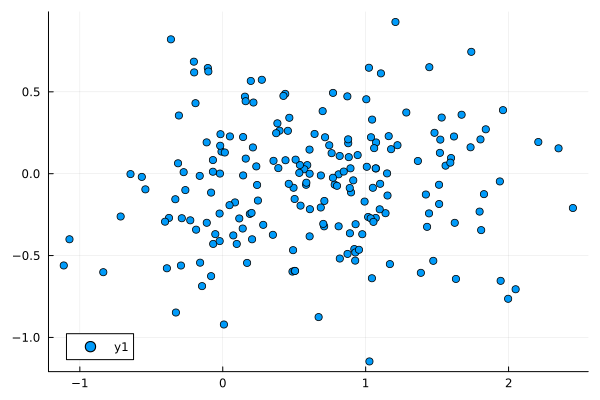

In [5]:
# Hidden states (accessible only in simulation)
scatter(Xd[1,:], Xd[2,:])

In [6]:
using DataConformingDeePC

In [7]:
function simulateDeePC(Ud, Yd, Tᵢₙᵢ, T_sim, γ)
    # Run closed-loop simulation, initialized by the above sequences (as initial conditions)
        
        U_rec = fill(NaN, size(Ud)[1], T_sim)
        X_rec = fill(NaN, size(Xd)[1], T_sim + 1)
        X_rec[:,1] = zeros(size(Xd)[1])
        Y_rec = fill(NaN, size(Yd)[1], T_sim + 1)
        Constrained = true
        prob = DeePC_struct(Q, R, N, Ud, Yd, Tᵢₙᵢ, Constrained)
        # In this case 
        if Constrained
            Ay = 1.0 * I(1)
            by = 2.0 * ones(1)
            Au = bu = nothing
        end
        prob.constraintMatrices = ConstraintMatrices(Ay, by, Au, bu)
        Uᵢₙᵢ = Ud[:,end-Tᵢₙᵢ+1:end]
        Yᵢₙᵢ = Yd[:,end-Tᵢₙᵢ+1:end]

        for i in 1:T_sim
            Uv = vec(Uᵢₙᵢ)
            Yv = vec(Yᵢₙᵢ)
            uₖ, yₖ = run_DeePC(prob, Uv, Yv, 
                    slack_var = false, λy=100.0, λg=1.0, γ = γ)
            if sum(abs.(yₖ)) >= 50 || any(isnan, yₖ)
                println("Final value of y is ", yₖ)
                println("System went unstable")
                return U_rec, X_rec, Y_rec, 1
                break
            end
            # First control only
            u₀ = uₖ[:,1]
            Uᵢₙᵢ[:,1:end-1] = Uᵢₙᵢ[:,2:end]
            Uᵢₙᵢ[:,end] = u₀
            x₀ = X_rec[:,i]
            x₁ = f(x₀, u₀)
            X_rec[:,i+1] = x₁
            U_rec[:,i] = u₀
            y₁ = g(x₁)
            Y_rec[:,i+1] = y₁
            Yᵢₙᵢ[:,1:end-1] = Yᵢₙᵢ[:,2:end]
            Yᵢₙᵢ[:,end] = y₁
            
            U_rec[:,i] = u₀
        end
    return U_rec, X_rec, Y_rec, 0
    end

simulateDeePC (generic function with 1 method)

In [8]:
using Plots.PlotMeasures

In [9]:
plt = plot(
    framestyle = :box,
    yguidefontsize = 10,
    xguidefontsize = 10,
    xtickfontsize = 8,
    ytickfontsize = 8,
    palette = :seaborn_muted,
    foreground_color_legend = nothing,
    legendfontsize=8,
    legend=:outerbottom,
    fontfamily = "Computer Modern",
    markersize = 2,
    xlabel = L"x_{1,k}",
    ylabel = L"x_{2,k}",
);

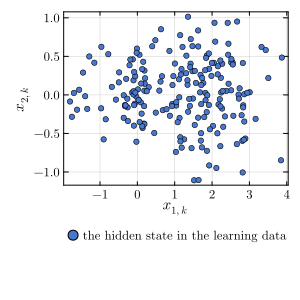

In [37]:
# The states corresponding to the training data
plot_grid_learning_data = scatter(plt, Xd[1,:], Xd[2,:], 
markersize = 3, size = (300, 300), label = "the hidden state in the learning data") 

In [20]:
Tᵢₙᵢ = 4
N = 8
T_sim = T;

In [39]:
γ = 5
U_rec, X_rec, Y_rec, instablility = simulateDeePC(Ud, Yd, Tᵢₙᵢ, T_sim, γ)
println("instablility is ", instablility)

instablility is 0


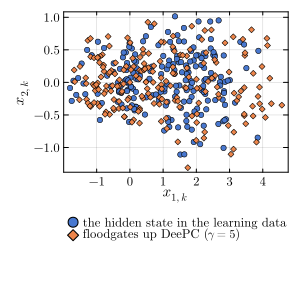

In [40]:
min_x = minimum([minimum(Xd[1,:]); minimum(X_rec[1,:])])
max_x = maximum([maximum(Xd[1,:]); maximum(X_rec[1,:])])
min_y = minimum([minimum(Xd[2,:]); minimum(X_rec[2,:])])
max_y = maximum([maximum(Xd[2,:]); maximum(X_rec[2,:])])
# The states corresponding to the when γ = 5
plot_grid_gamma_1 = scatter(plot_grid_learning_data, X_rec[1,:], X_rec[2,:], markershape = :diamond,
markersize = 3, size = (300, 300), label = L"floodgates up DeePC ($\gamma=5$)") 

In [41]:
γ = 0
U_rec, X_rec, Y_rec, instablility = simulateDeePC(Ud, Yd, Tᵢₙᵢ, T_sim, γ);

Final value of y is [NaN NaN NaN NaN NaN NaN NaN NaN NaN]
System went unstable


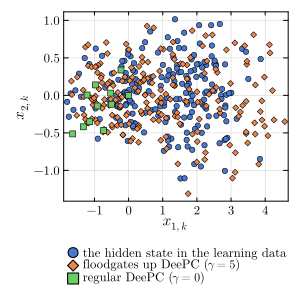

In [42]:
xlims = [min_x - 0.1, max_x + 0.1]
ylims = [min_y - 0.1, max_y + 0.1]
# The states corresponding to when γ = 0
plot_grid_gamma_zero = scatter(plot_grid_gamma_1, X_rec[1,:], X_rec[2,:], markershape = :rect,
markersize = 3, size = (300, 300), label = L"regular DeePC ($\gamma=0$)", 
xlims = xlims, ylims = ylims, bottom_margin = [-10mm 0mm]) 

In [43]:
plot_grid_gamma_zero
savefig("figs/statePlot.pdf")

"/Users/mohammad/Documents/GitHub/robust-less-dist-shifts/floodGatesUp-DeePC/figs/statePlot.pdf"

In [17]:
# Counting instabilities in a 100 runs
counter0 = 0
counter1 = 0
T_sim = 100
for j in 1:100
    unstable_exp = true
    while(unstable_exp)
        Ud, Xd, Yd = collectData(T, K);
        if any(isnan, Yd) || any(abs.(Yd) .>= 50)
            unstable_exp = true
        else
            unstable_exp = false
        end
    end
    Ud, Xd, Yd = collectData(T, K);
    γ = 0
    U_rec, X_rec, Y_rec, instablility = simulateDeePC(Ud, Yd, Tᵢₙᵢ, T_sim, γ);
    if instablility == 1
        counter0 += 1
    end

    γ = 5
    U_rec, X_rec, Y_rec, instablility = simulateDeePC(Ud, Yd, Tᵢₙᵢ, T_sim, γ);
    if instablility == 1
        counter1 += 1
    end
    println("Iteration: $j", "# of instabilities for γ = 0: $counter0, γ = 5: $counter1")
end

Final value of y is [-39.615470274119026 85.74363623660709 -47.68213413858614 -45.147001126642635 -2.1566935755979393 -58.628554042368684 -49.21905134870107 -0.4003224353242542 0.0]
System went unstable
Iteration: 1# of instabilities for γ = 0: 1, γ = 5: 0
Final value of y is [NaN NaN NaN NaN NaN NaN NaN NaN NaN]
System went unstable
Iteration: 2# of instabilities for γ = 0: 2, γ = 5: 0
Final value of y is [NaN NaN NaN NaN NaN NaN NaN NaN NaN]
System went unstable
Iteration: 3# of instabilities for γ = 0: 3, γ = 5: 0
Final value of y is [NaN NaN NaN NaN NaN NaN NaN NaN NaN]
System went unstable
Iteration: 4# of instabilities for γ = 0: 4, γ = 5: 0
Final value of y is [NaN NaN NaN NaN NaN NaN NaN NaN NaN]
System went unstable
Iteration: 5# of instabilities for γ = 0: 5, γ = 5: 0
Final value of y is [NaN NaN NaN NaN NaN NaN NaN NaN NaN]
System went unstable
Iteration: 6# of instabilities for γ = 0: 6, γ = 5: 0
Final value of y is [-35.007025126417 -208.992219861229 75.57960579638134 -23.